# Visualize gasoline prices at different gas stations in Mexico

### The main objective of carrying out this proyect was starting to utilize Jupyter Notebook to demonstrate a real world exercise on managing some database information. The gasoline price database was acquired from the <a href="https://datos.gob.mx/" target="_blank">official government website</a> to be able to do the analysis with real world data. I have decided to leave the errors that I got during developing my program to show a possible solution to this type of unexpected behavior we might find on other databases, this to show that sometimes we assume (me included) that the information we pull from the database is always written correctly (is not).

In [2]:
import pandas as pd
import os
import requests
import json
from functions import download
import xml.etree.ElementTree as et
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

On the first block of code we import all the modules we will use to create the map, extract the information, manipulate the data and convert the files we will download since they are XML files.

In [3]:
response = requests.get("https://datos.gob.mx/busca/api/3/action/package_search?q=gasolina")
dataDownload = response.json()
#dataDownload

We now use the "request" module we imported earlier to get the response from the webpage, we will utilize JSON format since its available.

In [4]:
urlLinkLocacion = dataDownload["result"]["results"][0]["resources"][0]["url"]
urlLinkPrecios = dataDownload["result"]["results"][0]["resources"][1]["url"]

We are doing this step to get the "url" where our information we need is located, it was necessary to read the JSON response we got to know the exact location of the link. I took this approach instead of downloading and adding the file to the proyect folder because we might not know when our database will be updated, so the structure of the webpage will be the same (assuming it will not change drastically) but our file might change, so using this approach we know that our program will always download the latest file from the page.

In this part, I utilized "functions.py" file to use the function called "download". This method downloads a file from a link, since we already have the exact location of the urls, we call the function and name our downloaded files to 'Precios.xml' and 'Lugar.xml'. We need both files since the location and prices of each location are on separated files, but we have a "place_id" to link the information.

In [5]:
pwd = os.getcwd()
download(urlLinkPrecios, pwd + '/Precios.xml')
download(urlLinkLocacion, pwd +'/Lugar.xml')

We extract the necessary information from our XML to build our prices dataframe.

In [6]:
df_cols = ["place_id", "gas_type", "gas_price"]
rows = []

xtree = et.parse(pwd + '/Precios.xml')
xroot = xtree.getroot() # Gets </places> tag as root

for node in xroot:
    placeId = node.attrib.get("place_id")  #Gets <place> attribute "place_id"
    for inside in node:
        gas_type = inside.attrib.get("type") #Gets <gas_price> attribute "type"
        gas_price = inside.text #Gets <gas_price> text "gas_price"
        rows.append({"place_id": placeId, "gas_type": gas_type, 
                 "gas_price": gas_price})

prices_df = pd.DataFrame(rows, columns= df_cols)
prices_df

,place_id,gas_type,gas_price
0,11703,regular,20.79
1,11703,premium,22.79
2,11702,regular,20.14
3,11702,premium,23.35
4,11702,diesel,21.5
...,...,...,...
33738,11704,premium,22.49
33739,11704,diesel,21.49
33740,2807,regular,19.95
33741,2807,diesel,21.99


We extract the necessary information from our XML to build our locations dataframe.

In [7]:
df_cols = ["place_id", "location_name", "latitude", "longitude"]
rows = []

xtree = et.parse(pwd + '/Lugar.xml')
xroot = xtree.getroot() # Gets </places> tag as root

for node in xroot:
    placeId = node.attrib.get("place_id")
    location_name = node.find("name").text
    for inside in node.iter("location"):
        latitude = inside.find("x").text
        longitude = inside.find("y").text

        rows.append({"place_id": placeId, "location_name": location_name, 
                "latitude": latitude, "longitude": longitude})

locations_df = pd.DataFrame(rows, columns= df_cols)
locations_df

,place_id,location_name,latitude,longitude
0,2039,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",-116.9214,32.47641
1,2040,"LAS MEJORES ESTACIONES, S.A DE C.V",-99.74484,20.3037
2,2041,"DIAZ GAS, S.A. DE C.V.",-106.4514,31.71947
3,2042,"COMBU-EXPRESS, S.A. DE C.V.",-103.3042,20.71413
4,2043,"PETROMAX, S.A. DE C.V.",-98.29977,26.03787
...,...,...,...,...
12890,27593,"SERVICIO EL LEONCITO, S.A. DE C.V.",-100.9331,21.81464
12891,27597,PRO M3 INFRAESTRUCTURA S.A. DE C.V.,-100.4573,20.82254
12892,27598,Servicio Cupula SA de CV,-98.91469,19.41953
12893,27599,"SERVICIO FACIL DEL SURESTE, S.A. DE C.V.",-94.95576,17.89041


We now merge both dataframes on the "place_id" to have the complete dataframe we are gonna use

In [8]:
gas_table = locations_df.merge(prices_df, how="left", on="place_id")
gas_table

,place_id,location_name,latitude,longitude,gas_type,gas_price
0,2039,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",-116.9214,32.47641,regular,19.49
1,2039,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",-116.9214,32.47641,diesel,20.19
2,2039,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",-116.9214,32.47641,premium,22.99
3,2040,"LAS MEJORES ESTACIONES, S.A DE C.V",-99.74484,20.3037,regular,20.79
4,2040,"LAS MEJORES ESTACIONES, S.A DE C.V",-99.74484,20.3037,premium,22.15
...,...,...,...,...,...,...
33984,27599,"SERVICIO FACIL DEL SURESTE, S.A. DE C.V.",-94.95576,17.89041,regular,19.59
33985,27599,"SERVICIO FACIL DEL SURESTE, S.A. DE C.V.",-94.95576,17.89041,premium,21.69
33986,27599,"SERVICIO FACIL DEL SURESTE, S.A. DE C.V.",-94.95576,17.89041,diesel,20.99
33987,27600,"SERVICIO FACIL DEL SURESTE, S.A. DE C.V.",-93.04568,17.98012,regular,20.04


We just make a copy of the dataframe

In [9]:
gas_table_modified = gas_table.copy()

What we do here is to pivot the information of the gas prices

In [10]:
gas_table_pivot = gas_table_modified.pivot(index=['place_id', 'location_name', "latitude", "longitude"], columns='gas_type', values="gas_price").reset_index()
gas_table_pivot

gas_type,place_id,location_name,latitude,longitude,NaN,diesel,premium,regular
0,10000,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-99.17684,23.75344,NaN,21.95,23.49,19.95
1,10001,SERVICIOS PALO VERDES SA DE CV,-109.9156,27.46514,NaN,22.1,22.99,18.98
2,10002,ELIO LOPEZ DOMINGUEZ,-97.64679,19.13942,NaN,16.79,17.6,15.87
3,10003,SERVICIO LINDA VISTA SA DE CV,-106.4816,31.69662,NaN,NaN,NaN,14.99
4,10004,ALEJANDRO MANUEL MENDEZ HURTADO,-102.0301,19.40397,NaN,21.75,21.95,19.85
...,...,...,...,...,...,...,...,...
12890,9995,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-100.3123,25.68669,NaN,NaN,23.89,21.48
12891,9996,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-100.1816,25.70952,NaN,21.19,22.79,20.59
12892,9997,ENERGETICOS LA VALENTINA SA DE CV,-103.585,19.88209,NaN,21.89,22.29,20.79
12893,9998,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-100.4493,25.65615,NaN,NaN,23.89,21.59


We now drop the NaN column resulting from the pivot

In [11]:
gas_table_pivot = gas_table_pivot[['place_id','location_name','latitude','longitude','diesel','premium','regular']]
gas_table_pivot

gas_type,place_id,location_name,latitude,longitude,diesel,premium,regular
0,10000,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-99.17684,23.75344,21.95,23.49,19.95
1,10001,SERVICIOS PALO VERDES SA DE CV,-109.9156,27.46514,22.1,22.99,18.98
2,10002,ELIO LOPEZ DOMINGUEZ,-97.64679,19.13942,16.79,17.6,15.87
3,10003,SERVICIO LINDA VISTA SA DE CV,-106.4816,31.69662,NaN,NaN,14.99
4,10004,ALEJANDRO MANUEL MENDEZ HURTADO,-102.0301,19.40397,21.75,21.95,19.85
...,...,...,...,...,...,...,...
12890,9995,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-100.3123,25.68669,NaN,23.89,21.48
12891,9996,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-100.1816,25.70952,21.19,22.79,20.59
12892,9997,ENERGETICOS LA VALENTINA SA DE CV,-103.585,19.88209,21.89,22.29,20.79
12893,9998,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-100.4493,25.65615,NaN,23.89,21.59


We fill any N/A column with "0"

In [12]:
gas_table_pivot = gas_table_pivot.fillna(0)

In this step, we will now use the GeoPandas to be able load andshow our information on a map, in this case we will select only Mexico 

<AxesSubplot:>

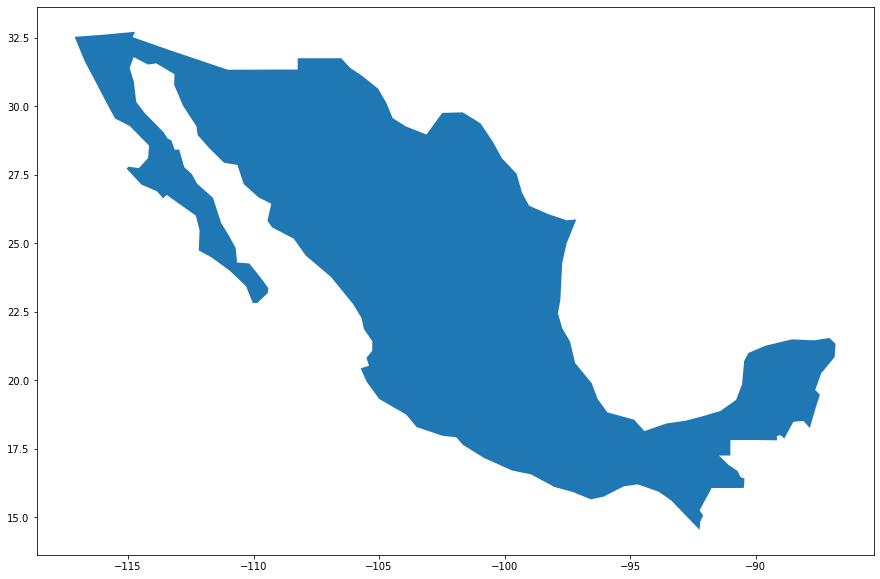

In [13]:
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = countries[countries["name"] == "Mexico"]
fig, ax = plt.subplots(figsize = (15,15))
countries.plot(ax=ax)

For testing purposes, we will try to map only one location of the map just to see that our information is showing correctly, in this case we selected the "SERVICIO COSTA NORTE DE JALISCO S.A. DE C.V." to be our test location

In [14]:
local = gas_table_pivot.loc[gas_table_pivot["location_name"] == 'SERVICIO COSTA NORTE DE JALISCO S.A. DE C.V.' ]

In [15]:
geometry = [Point(xy) for xy in zip(pd.to_numeric(local['latitude']), pd.to_numeric(local['longitude']))]
geometry[:3]

In [16]:
geo_df = gpd.GeoDataFrame(local, crs="EPSG:4326", geometry = geometry)

We then now plot the location on our map and we verify that the "SERVICIO COSTA NORTE DE JALISCO S.A. DE C.V." is located at Jalisco, so its working!

<AxesSubplot:>

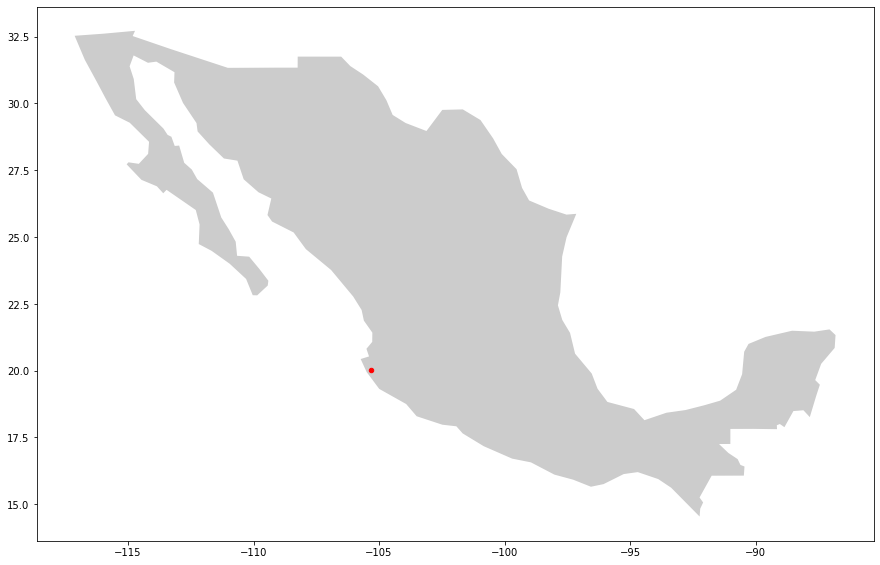

In [17]:
fig, ax = plt.subplots(figsize = (15,15))
countries.plot(ax = ax, alpha = 0.4, color ="grey")
geo_df.plot(ax = ax, markersize = 20, color ="red" , marker='o', label="Neg")

When working with the data, I did notice some inconsistencies on the data that might affect our mapping, in this case, we had that the location of "INMOBILIARIA HOTELA S.A. DE C.V." was complety incorrect as we have values of 355773.1 for the latitude and 2272.49 of longitude 

In [18]:
gas_table_pivot.loc[gas_table_pivot["longitude"].astype(float).astype(int) > 100]

gas_type,place_id,location_name,latitude,longitude,diesel,premium,regular
4264,23393,INMOBILIARIA HOTELA S.A. DE C.V.,355773.1,2272.49,20.78,21.78,19.78


In [19]:
gas_table_pivot.loc[gas_table_pivot["latitude"].astype(float).astype(int) > 100]

gas_type,place_id,location_name,latitude,longitude,diesel,premium,regular
4188,23170,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",101.5987,21.07213,21.89,22.99,19.59
4189,23172,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",102.2409,21.28889,21.79,22.99,20.79
4191,23175,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",101.0294,25.40808,20.16,22.99,20.68
4193,23177,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",101.49,20.98868,21.45,22.89,20.29
4228,23283,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",101.7925,21.04617,21.99,23.19,20.59
4231,23286,COMERCIALIZADORA DE COMBUSTIBLES RICO SA DE CV,105.4387,28.19517,22.08,22.3,20.3
4264,23393,INMOBILIARIA HOTELA S.A. DE C.V.,355773.1,2272.49,20.78,21.78,19.78
4397,24030,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",101.5753,21.22296,22.19,23.59,20.99
4398,24031,"SERVIAVILAS, S.A. DE C.V.",108.0921,25.19903,19.94,22.64,19.79
4454,24164,"COMBU-EXPRESS, S.A. DE C.V.",103.4439,19.63984,22.26,22.49,21.44


So to do a quick fix on that location, I used the index table (The index table changed since we used the pivot function) "gas_type" and update that information with the real values we get on the internet

In [20]:
gas_table_pivot.loc[gas_table_pivot["location_name"] == 'INMOBILIARIA HOTELA S.A. DE C.V.']

gas_type,place_id,location_name,latitude,longitude,diesel,premium,regular
4264,23393,INMOBILIARIA HOTELA S.A. DE C.V.,355773.1,2272.49,20.78,21.78,19.78


In [21]:
gas_table_pivot.iat[4264, 2] = -100.3
gas_table_pivot.iat[4264, 3] = 20.5

In [22]:
gas_table_pivot.loc[gas_table_pivot["location_name"] == 'INMOBILIARIA HOTELA S.A. DE C.V.']

gas_type,place_id,location_name,latitude,longitude,diesel,premium,regular
4264,23393,INMOBILIARIA HOTELA S.A. DE C.V.,-100.3,20.5,20.78,21.78,19.78


<AxesSubplot:>

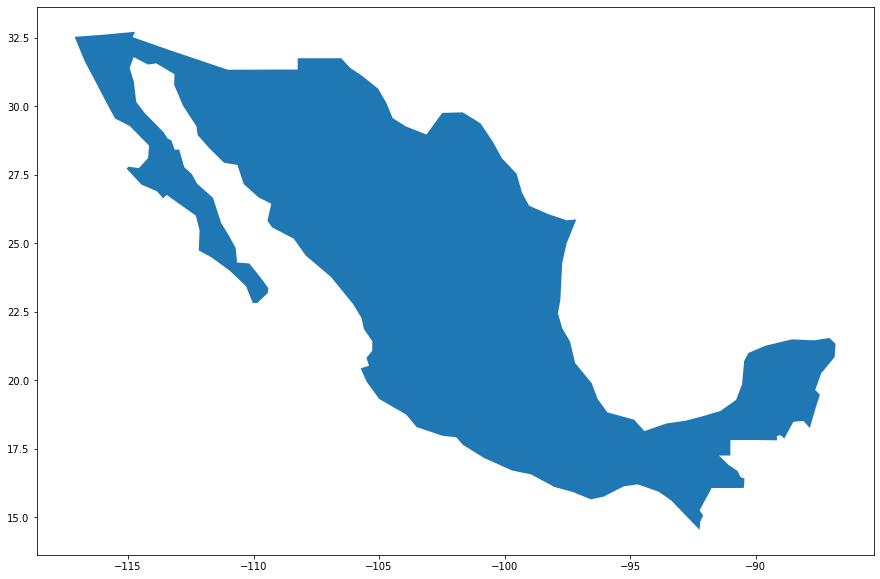

In [23]:
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = countries[countries["name"] == "Mexico"]
fig, ax = plt.subplots(figsize = (15,15))
countries.plot(ax=ax)

In [24]:
geometry = [Point(xy) for xy in zip(pd.to_numeric(gas_table_pivot['latitude']), pd.to_numeric(gas_table_pivot['longitude']))]
geometry[:3]

In [25]:
geo_df = gpd.GeoDataFrame(gas_table_pivot, crs="EPSG:4326", geometry = geometry)

Since we already tried with the location "SERVICIO COSTA NORTE DE JALISCO S.A. DE C.V." mentioned earlier, we now try to map the location of every row since we know our logic works, but we got the next result.

<AxesSubplot:>

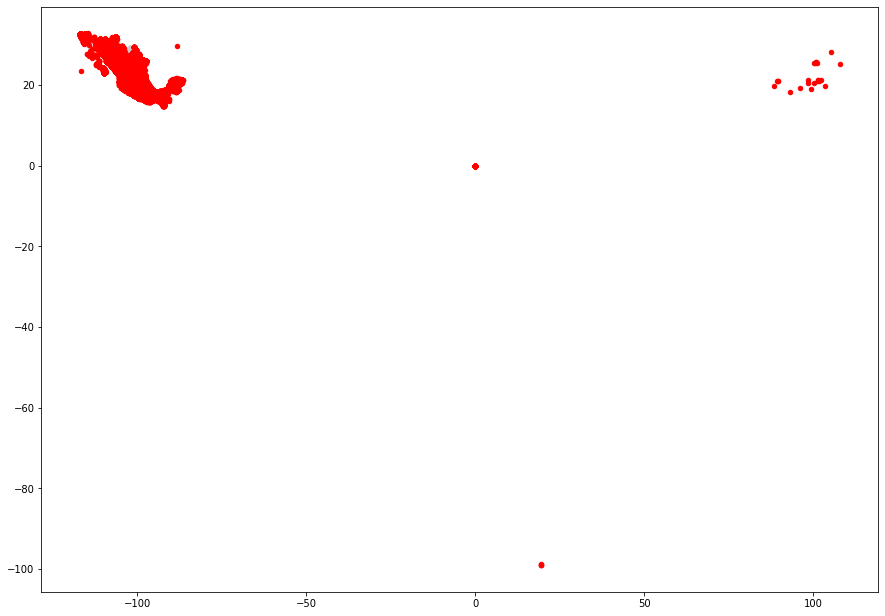

In [26]:
fig, ax = plt.subplots(figsize = (15,15))
countries.plot(ax = ax, alpha = 0.4, color ="grey")
geo_df.plot(ax = ax, markersize = 20, color ="red" , marker='o', label="Neg")

This is the result of mapping every location we have on our dataframe, but theres inconsitencies that we need to solve to be able to map the data correctly: 
1. We are trying to map locations that have no latitude or longitude.
2. We have a location that they have the latitude and longitude inverted

In [27]:
#Need to remove outliers

gas_table_pivot.loc[gas_table_pivot["latitude"].astype(float).astype(int) == 0] #Needs to be removed

gas_table_pivot.loc[gas_table_pivot["latitude"].astype(float).astype(int) > 0] #Needs to be negative


gas_type,place_id,location_name,latitude,longitude,diesel,premium,regular,geometry
4188,23170,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",101.5987,21.07213,21.89,22.99,19.59,POINT (101.59870 21.07213)
4189,23172,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",102.2409,21.28889,21.79,22.99,20.79,POINT (102.24090 21.28889)
4190,23173,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",100.9228,25.52974,21.88,22.99,20.88,POINT (100.92280 25.52974)
4191,23175,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",101.0294,25.40808,20.16,22.99,20.68,POINT (101.02940 25.40808)
4192,23176,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",100.8471,25.61313,21.89,22.99,21.09,POINT (100.84710 25.61313)
4193,23177,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",101.49,20.98868,21.45,22.89,20.29,POINT (101.49000 20.98868)
4208,23219,GRUPO ENERGETICO DE LA CHONTALPA S.A. DE C.V.,93.20781,18.29521,21.6,23.2,20.36,POINT (93.20781 18.29521)
4227,23282,CARBURANTES DE YUCATAN SA DE CV,89.56924,21.01828,0,22.49,20.99,POINT (89.56924 21.01828)
4228,23283,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",101.7925,21.04617,21.99,23.19,20.59,POINT (101.79250 21.04617)
4231,23286,COMERCIALIZADORA DE COMBUSTIBLES RICO SA DE CV,105.4387,28.19517,22.08,22.3,20.3,POINT (105.43870 28.19517)


In [ ]:
Index_label_zeros = gas_table_pivot[gas_table_pivot['latitude'].astype(float).astype(int) == 0].index.tolist()
Index_label_zeros

In [29]:
gas_table_pivot = gas_table_pivot.drop(labels=Index_label_zeros, axis=0)

In [ ]:
# Latitude must be negative since the values are mapped incorrect on our map
Index_label = gas_table_pivot.loc[gas_table_pivot["latitude"].astype(float).astype(int) > 50].index.tolist()
Index_label

In [ ]:
df_temp = gas_table_pivot.loc[Index_label, 'latitude']
df_temp = '-' + df_temp.loc[Index_label]
df_temp

In [32]:
#gas_table_pivot.loc[Index_label, 'latitude'] = gas_table_pivot['longitude']

In [33]:
gas_table_pivot.loc[Index_label, 'latitude'] = df_temp[Index_label]
gas_table_pivot.loc[Index_label]

gas_type,place_id,location_name,latitude,longitude,diesel,premium,regular,geometry
4188,23170,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-101.5987,21.07213,21.89,22.99,19.59,POINT (101.59870 21.07213)
4189,23172,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-102.2409,21.28889,21.79,22.99,20.79,POINT (102.24090 21.28889)
4190,23173,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-100.9228,25.52974,21.88,22.99,20.88,POINT (100.92280 25.52974)
4191,23175,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-101.0294,25.40808,20.16,22.99,20.68,POINT (101.02940 25.40808)
4192,23176,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-100.8471,25.61313,21.89,22.99,21.09,POINT (100.84710 25.61313)
4193,23177,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-101.49,20.98868,21.45,22.89,20.29,POINT (101.49000 20.98868)
4208,23219,GRUPO ENERGETICO DE LA CHONTALPA S.A. DE C.V.,-93.20781,18.29521,21.6,23.2,20.36,POINT (93.20781 18.29521)
4227,23282,CARBURANTES DE YUCATAN SA DE CV,-89.56924,21.01828,0,22.49,20.99,POINT (89.56924 21.01828)
4228,23283,"SERVICIOS GASOLINEROS DE MEXICO, S.A. DE C.V.",-101.7925,21.04617,21.99,23.19,20.59,POINT (101.79250 21.04617)
4231,23286,COMERCIALIZADORA DE COMBUSTIBLES RICO SA DE CV,-105.4387,28.19517,22.08,22.3,20.3,POINT (105.43870 28.19517)


In [34]:
# We now need to get the case where we do have the correct latitude negative value but is flipped with the longitude location

#We run this part of code to get the indices of where we need to change 
Index_label = gas_table_pivot.loc[gas_table_pivot["latitude"].astype(float).astype(int) > 0].index.tolist()
Index_label

[8707, 8747, 9919, 10041]

In [35]:
#We can see the latitude is 19 but thats the longitude value, so we need to flip this values
gas_table_pivot.loc[Index_label]

gas_type,place_id,location_name,latitude,longitude,diesel,premium,regular,geometry
8707,5812,"SOLUCIONES P&L, S.A.P.I. DE C.V.",19.41447,-99.03223,21.69,22.49,20.49,POINT (19.414 -99.032)
8747,5852,"SOLUCIONES P&L, S.A.P.I. DE C.V.",19.3882,-99.02986,0,22.49,20.49,POINT (19.388 -99.030)
9919,7024,"SOLUCIONES P&L, S.A.P.I. DE C.V.",19.48694,-99.03712,21.99,22.59,20.59,POINT (19.487 -99.037)
10041,7146,"SOLUCIONES P&L, S.A.P.I. DE C.V.",19.35144,-98.85688,21.59,22.59,20.49,POINT (19.351 -98.857)


In [36]:
# We use a temporary variable to store the latitude value since it will be lost when we changed the latitude to be the longitude
df_temp2 = gas_table_pivot.loc[Index_label, 'latitude']

In [37]:
gas_table_pivot.loc[Index_label, 'latitude'] = gas_table_pivot['longitude']

In [38]:
gas_table_pivot.loc[Index_label, 'longitude'] = df_temp2[Index_label]

In [39]:
geometry = [Point(xy) for xy in zip(pd.to_numeric(gas_table_pivot['latitude']), pd.to_numeric(gas_table_pivot['longitude']))]
geometry[:3]

In [40]:
geo_df = gpd.GeoDataFrame(gas_table_pivot, crs="EPSG:4326", geometry = geometry)

After fixing this errors, we now get our map correctly representing all the gas stations in Mexico! (Theres two locations that are mapped incorrectly on the sea, but we got pretty close). We then can use some queries to know some information of the database and show that information on the map!

<AxesSubplot:>

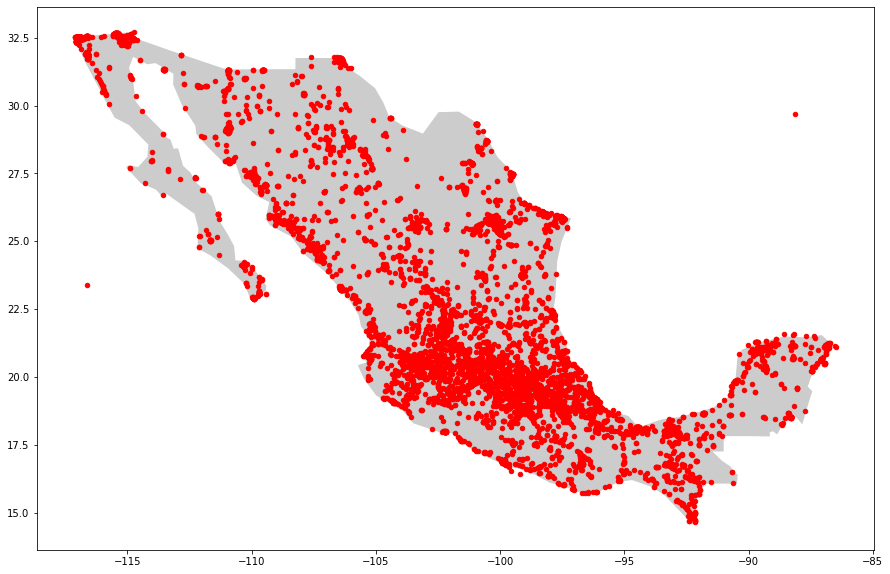

In [41]:
fig, ax = plt.subplots(figsize = (15,15))
countries.plot(ax = ax, alpha = 0.4, color ="grey")
geo_df.plot(ax = ax, markersize = 20, color ="red" , marker='o', label="Neg")

We know we can visualize information on our map, so we can now for example, show which gas stations sell the regular gas type above 20 pesos, and which ones sell the premium above 23 pesos. First we will start building the dataframe with the regular then the premium one 

In [ ]:
tempRegular = gas_table_pivot.loc[gas_table_pivot["regular"].astype(float).astype(int) > 20]
geometryRegularPriceAbove20 = [Point(xy) for xy in zip(pd.to_numeric(tempRegular['latitude']), pd.to_numeric(tempRegular['longitude']))]
geometryRegularPriceAbove20[:3]

In [ ]:
tempPremium = gas_table_pivot.loc[gas_table_pivot["premium"].astype(float).astype(int) > 23]
geometryPremiumPriceAbove23 = [Point(xy) for xy in zip(pd.to_numeric(tempPremium['latitude']), pd.to_numeric(tempPremium['longitude']))]
geometryPremiumPriceAbove23[:3]

We know show this information on our map, so for the regular one, we use color "green" (since its the color we get for that particular gas type) and the "o" marker, for the premium one, we go for the color "red" (since its the color we get for that particular gas type) and the marker "x". So we can now visualize our data on the map!

<AxesSubplot:>

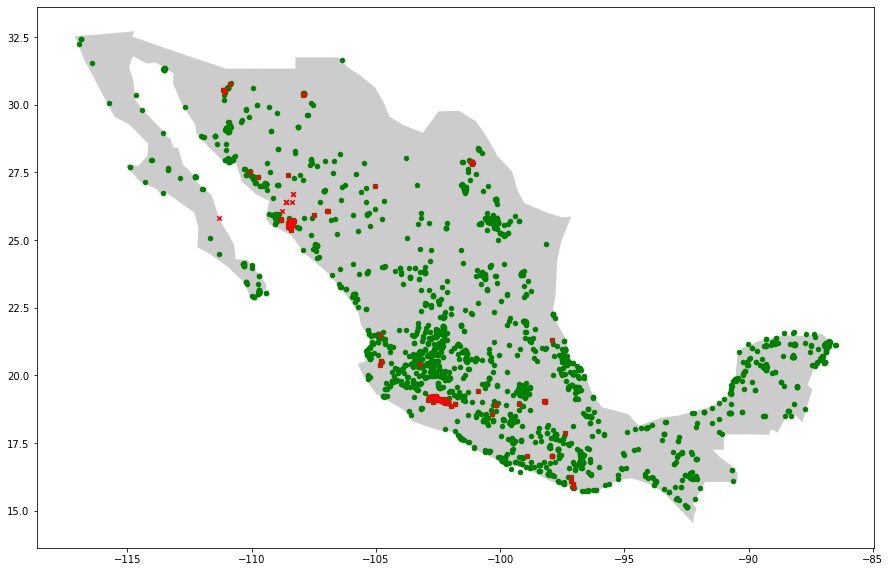

In [55]:
geo_dfRegularPrices = gpd.GeoDataFrame(tempRegular, crs="EPSG:4326", geometry = geometryRegularPriceAbove20)
geo_dfPremiumPrices = gpd.GeoDataFrame(tempPremium, crs="EPSG:4326", geometry = geometryPremiumPriceAbove23)


fig, ax = plt.subplots(figsize = (15,15))
countries.plot(ax = ax, alpha = 0.4, color ="grey")
geo_dfRegularPrices.plot(ax = ax, markersize = 20, color ="green" , marker='o', label="Neg")
geo_dfPremiumPrices.plot(ax = ax, markersize = 20, color ="red" , marker='x', label="Neg")


Another querie we can write is to visualize how many locations sell diesel. So we will build the dataframe

In [56]:
tempDiesel = gas_table_pivot.loc[gas_table_pivot["diesel"].astype(float).astype(int) > 0]
geometryDiesel = [Point(xy) for xy in zip(pd.to_numeric(tempDiesel['latitude']), pd.to_numeric(tempDiesel['longitude']))]
geometryDiesel[:3]

We can see that almost every gas station sells diesel.

<AxesSubplot:>

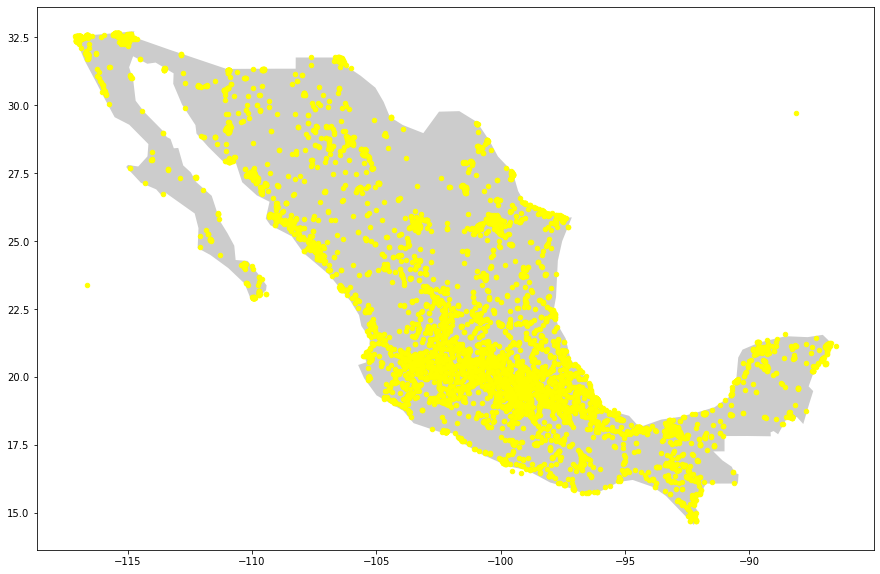

In [57]:
geo_dfDiesel = gpd.GeoDataFrame(tempDiesel, crs="EPSG:4326", geometry = geometryDiesel)

fig, ax = plt.subplots(figsize = (15,15))
countries.plot(ax = ax, alpha = 0.4, color ="grey")
geo_dfDiesel.plot(ax = ax, markersize = 20, color ="yellow" , marker='o', label="Neg")

## And there are other examples that we could use to filter our information and visualize it, but for the time being this is the end of a fun exercise that worked for me to get to know how Jupyter Notebooks work, GeoPandas, and other tools utilized, until next time!